### **本节是更复杂的计算层**

**一，Affine层的计算**

为什么叫做Affine层？

神经网络的正向传播中进行的矩阵的乘积运算在几何学领域被称为“仿射变换”。因此，这里将进行仿射变换的处理实现为“Affine层”

**Affine层的计算图**：

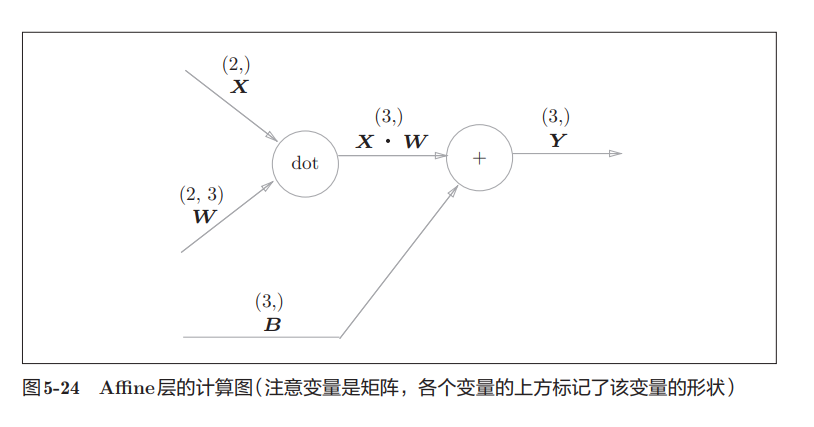

**难点：矩阵的求导** 

公式如下（粗体的为**矩阵**，注意矩阵乘积的顺序）：

$ \dfrac{\partial L}{\partial \bf{X}} = \dfrac{\partial L}{\partial \bf{Y}} \cdot {{\bf W}^T} $

$ \dfrac{\partial L}{\partial \bf{W}} = {{\bf X}^T} \cdot \dfrac{\partial L}{\partial \bf{Y}} $

原理：**根据矩阵的形状来定的**，例如输入X是（3，），那么结果对X求导也一定是（3，）

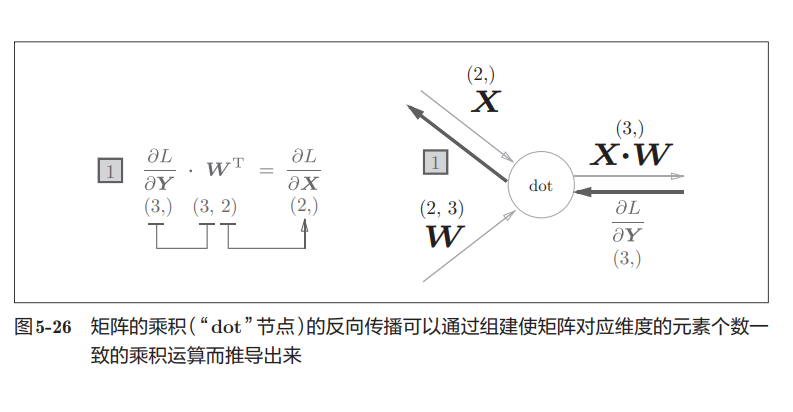

***
**二，批版本的Affine层**

前面介绍的Affi ne层的输入X是**以单个数据**为对象的。现在我们考虑**N个数据**一起进行正向传播的情况，也就是批版本的Affine层。

计算图如下：

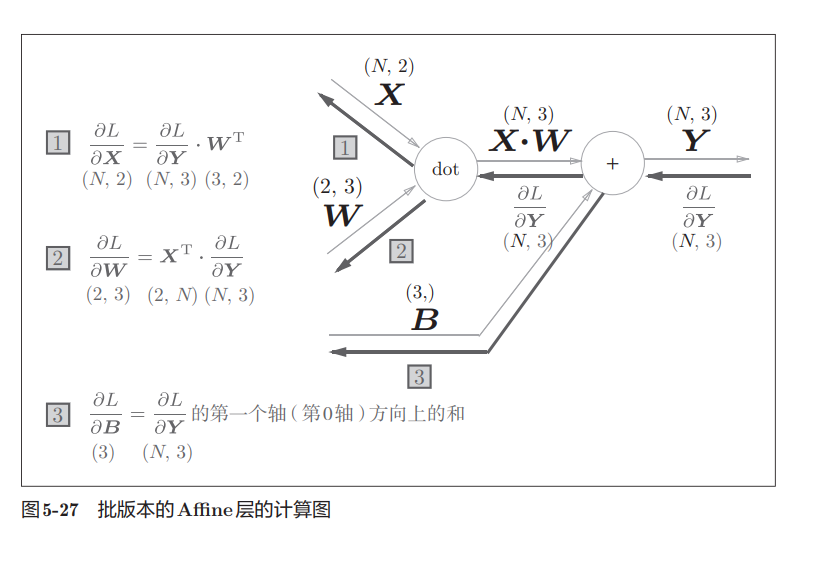

**注意：偏置在批处理时的计算进行了广播，分别加到了各个数据上**

In [5]:
# 导入包
import numpy as np

In [4]:
# 偏置矩阵广播
X_dot_W = np.array([[0,0,0],[10,10,10]])
B = np.array([1,2,3])
print(B + X_dot_W)

[[ 1  2  3]
 [11 12 13]]


**正向传播时，偏置会被加到每一个数据（第1个、第2个……）上。因此，  
反向传播时，各个数据的反向传播的值需要汇总为偏置的元素。**

In [6]:
dY = np.array([[1,2,3],[4,5,6]])
dB = np.sum(dY,axis = 0)
print(dB)

[5 7 9]


***
**故综上所述，Affine计算层的实现如下**：

In [8]:
# 兼容批处理的Affine层的实现
class Affine:
    """Affine仿射层"""

    def __init__(self,W,b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self,x):
        self.x = x
        out = np.dot(x,self.W) + self.b

        return out
    
    def backward(self,dout):
        dx = np.dot(dout,self.W.T) # 注意这里的矩阵乘法，W进行了转置
        self.dW = np.dot(self.x.T,dout) # 同样要转置，对应矩阵求导公式
        self.db = np.sum(dout,axis = 0)

        return dx

**三，复杂的Softmax-with-Loss层**

由于推导过程1较为复杂，直接给图及结论：

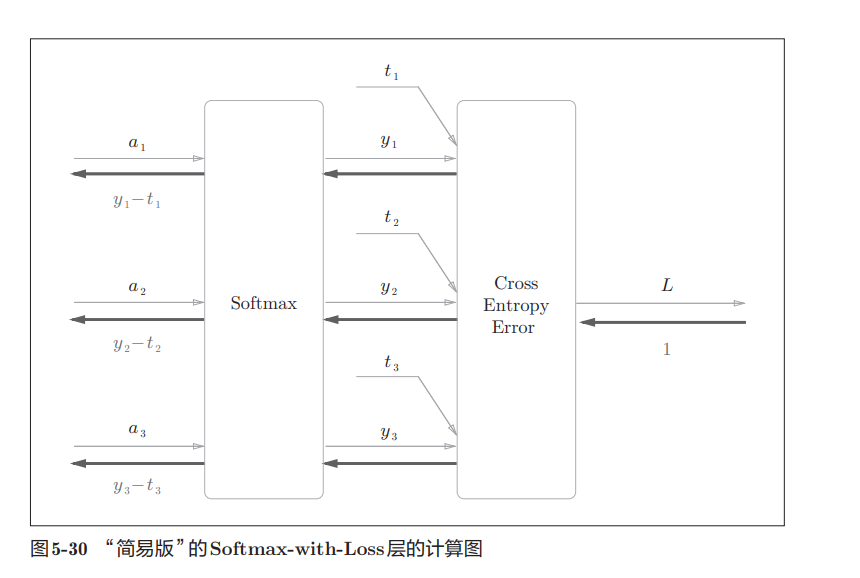

会发现反向传播的结果非常漂亮，为什么?

使用**交叉熵误差**作为softmax函数的损失函数后，反向传播得到（y1 − t1, y2 − t2, y3 − t3）这样“漂亮”的结果。  
实际上，这样“漂亮”的结果**并不是偶然的**，而是为了得到这样的结果，**特意设计了交叉熵误差函数**。

**样例理解**：  
这里考虑一个具体的例子，比如思考教师标签是（0, 1, 0），Softmax层  
的输出是(0.3, 0.2, 0.5)的情形。因为正确解标签处的概率是0.2（20%），这个  
时候的神经网络未能进行正确的识别。此时，Softmax层的反向传播传递的  
是(0.3, −0.8, 0.5)这样一个**大的误差**。**因为这个大的误差会向前面的层传播，  
所以Softmax层前面的层会从这个大的误差中学习到“大”的内容**  

再举一个例子，比如思考教师标签是(0, 1, 0)，Softmax层的输出是(0.01,   
0.99, 0)的情形（这个神经网络识别得相当准确）。此时Softmax层的反向传播  
传递的是(0.01, −0.01, 0)这样一个小的误差。这个小的误差也会向前面的层  
传播，因为**误差很小**，**所以Softmax层前面的层学到的内容也很“小”**。  

**下面是Softmax-with-Loss层的实现**

In [1]:
# 需要导入框架
import my_frame as mf

# 构建Softmax-with-Loss层
class SoftmaxWithLoss:
    """Softmax正规化及交叉熵损失层"""

    def __init__(self):
        self.loss = None # 损失
        self.y = None # softmax的输出
        self.t = None # 监督数据(要求one-hot格式的)

    def forward(self,x,t):
        self.t = t
        self.y = mf.softmax(x)
        self.loss = mf.cross_entropy_error(self.y,self.t)

        return self.loss
    
    def backward(self,dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size # 计算单个输入数据的导数，应该叫做误差

        return dx